# 2. SuperSubj Level Broadband

In [1]:
import pandas as pd
import numpy as np
import os
import json

import seaborn as sns
import matplotlib.pyplot as plt
from nilearn import plotting
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy.cluster.hierarchy import linkage, fcluster

from sklearn.decomposition import PCA
from scipy.stats import spearmanr

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


In [2]:
from utils import OUT_PATH, PROJECT_PATH
from utils import PlotCompoIndividual, BbEvents, GetInfo, CompoThr, ExcludSubj

epoch_path = '/users/barbara/Desktop/MIB/outs/Data'
subj_included = [file.replace('_epochs.p', '') for file in os.listdir(epoch_path) if file[-len('epochs.p'):] == 'epochs.p']
subj_included = ExcludSubj(subj_included)
print('Number of subject is ', len(subj_included))

Number of subject is  30


## PCA

In [3]:
# grp level
data_mean_list = []

for subj in subj_included: # go over the subject and comptute mean per condi over trials
    # get the band 
    data_mean = BbEvents(subj)
    data_mean_list.append(data_mean)
    
data_grp = np.hstack(data_mean_list)
data_grp_mean = data_grp.mean(0)

nb_compo = 3
pca = PCA(nb_compo)
pca.fit(data_grp_mean.T)

df_Compo = pd.DataFrame(pca.components_)
df_Compo['compo'] = ['compo'  +str(i+1) for i in range(nb_compo)]
df_Compo['freq'] = ['broadband']*nb_compo 
ev = pca.explained_variance_ratio_
data_transfrom = np.zeros((2, nb_compo, data_grp.shape[2]))
data_transfrom[0, :, :] = pca.transform(data_grp[0, :,:].T).T
data_transfrom[1, :, :] = pca.transform(data_grp[1, :,:].T).T

PlotCompoIndividual('grp', df_Componants={'grp' : df_Compo}, nb_compo = nb_compo,freq_band=['broadband'], out_path= OUT_PATH + '/grpPCA/supsubj_bb_mean/')

 # get the info 
info_file = f'{OUT_PATH}/Data/{subj}_info.json'
with open(info_file) as f:
    info = json.load(f)
    time = info['time_epoch']

fig, ax = plt.subplots(1,nb_compo, figsize = (14, 4), sharey=True)
fig.suptitle(f'Group PCs (Broadband)')

for i in range(nb_compo) : 
    ax[i].plot(time, data_transfrom[0, i,:], c = 'blue', label='old/correct', alpha = 0.7)
    ax[i].plot(time, data_transfrom[1, i,:], c = 'red', label='new/correct', alpha = 0.7)
    ax[i].set_title(f'PC {str(i+1)} --  ev : {np.round(ev[i], 2)}')
ax[i].legend()
plt.savefig(OUT_PATH + f'/grpPCA/supsubj_bb_mean/grp_TimeSeries.png')
plt.close()

# Save
df_X_transform = pd.DataFrame(np.concat([data_transfrom[0, :, :], data_transfrom[1, :, :]], axis=1))
df_X_transform['freq'] = 'broadband'
df_X_transform['subj'] = 'grp'
df_X_transform['compo'] = ['compo' + str(i+1) for i in range(nb_compo)]

df_X_transform.to_csv(f'{OUT_PATH}/grpPCA/supsubj_bb_mean/grp_Xtrans_PCA{nb_compo}.csv')
df_Compo.to_csv(f'{OUT_PATH}/grpPCA/supsubj_bb_mean/grp_Compo_PCA{nb_compo}.csv')


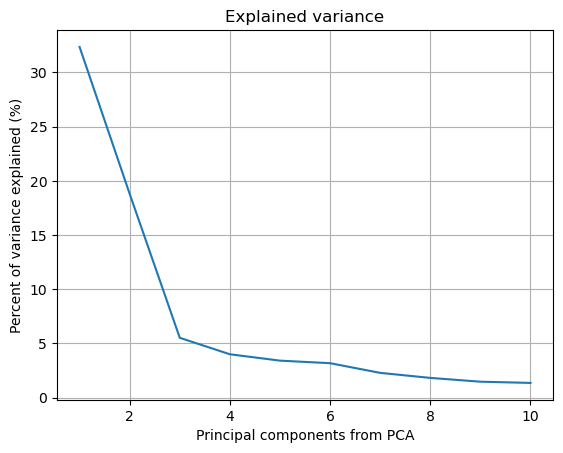

In [4]:
# Get the explain var
colors = plt.get_cmap('tab10')
pca = PCA(10)
pca.fit(data_grp_mean.T)
plt.plot(np.arange(10)+1, pca.explained_variance_ratio_*100)
plt.grid()
plt.title('Explained variance')
plt.xlabel('Principal components from PCA')
plt.ylabel('Percent of variance explained (%)')
plt.show()


## COMPO ANALYSIS

In [5]:
grp_compo=pd.read_csv(f'{OUT_PATH}/grpPCA/supsubj_bb_mean/grp_Compo_PCA{nb_compo}.csv').drop(columns = 'Unnamed: 0')
coord, areas, elect_list = GetInfo(subj_included)
coord_array = np.array(coord)

#### Distribution

In [6]:
# Distribution
data = grp_compo.query("freq == 'broadband'").drop(columns = ['compo', 'freq']).values
data_thr = CompoThr(data, replace = np.nan)

df_data = pd.DataFrame(np.concat([np.array(elect_list).reshape(len(elect_list), 1),np.array(areas)[:, 0].reshape(len(areas), 1), data_thr.T], axis = 1)).rename(columns = {0 : 'elect', 1: 'area', 2:1, 3:2, 4:3, 5:4, 6:5})
df_data[[1, 2, 3]] = df_data[[1, 2, 3]].astype(float)

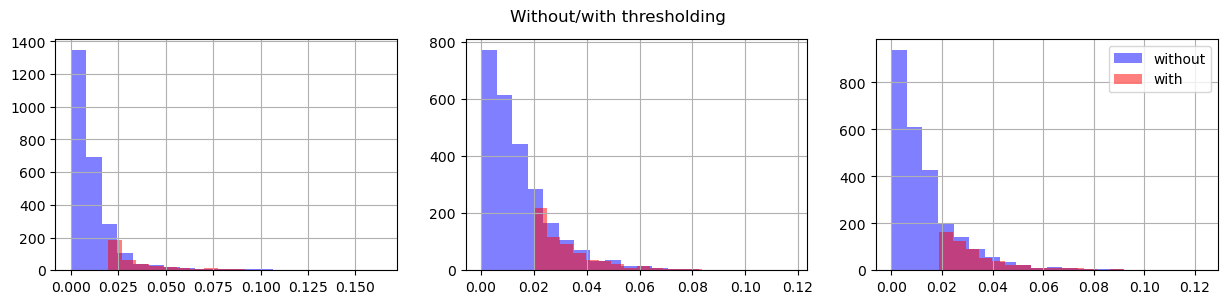

In [7]:
fig, axs = plt.subplots(1, nb_compo, figsize = (15, 3))
fig.suptitle('Without/with thresholding')

df = grp_compo.set_index('compo').drop(columns = ['freq'])
df_thr = df_data[[1, 2, 3]].T
df_thr['compo'] = ['compo' + str(i+1) for i in range(len(df_thr))]
df_thr= df_thr.set_index('compo')

for i, ax in enumerate(axs) : 
    df.loc['compo' + str(i+1), :].apply(lambda x : abs(x)).hist(bins=20, ax=ax, alpha = 0.5, color = 'blue', label = 'without', )
    df_thr.loc['compo' + str(i+1), :].apply(lambda x : abs(x)).hist(bins=20, ax=ax, alpha = 0.5, color = 'red', label='with')   

ax.legend()

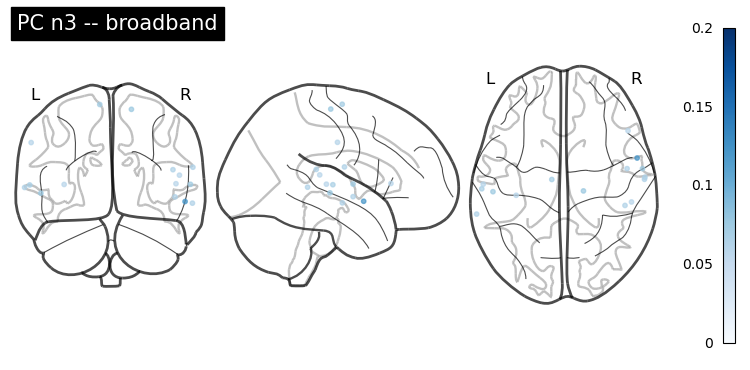

In [8]:
nb_el = 20
largest_list={}
fig, axs = plt.subplots(1, nb_compo, figsize = (5*nb_compo, 5), sharey=True)
fig.suptitle(f'{nb_el} drivers channels by area -- Broadband')
fig.tight_layout()
largest_list = []
for i, ax in enumerate(axs) : 
    largest = df_data.nlargest(nb_el, i+1)[['elect', 'area', i+1]]
    largest_list.append(largest)
    sns.histplot(largest, x= 'area', element='bars', alpha = 0.3, ax=ax)
    ax.tick_params(axis='x', rotation=90, size = 3)
    ax.set_title('PC' + str(i+1))

    fig1 = plotting.plot_markers(node_coords = coord_array[largest.index],  node_size=10, node_values=largest[i+1], node_cmap='Blues', title=f'PC n{i+1} -- broadband',display_mode='ortho', node_vmin=0, node_vmax=0.2)

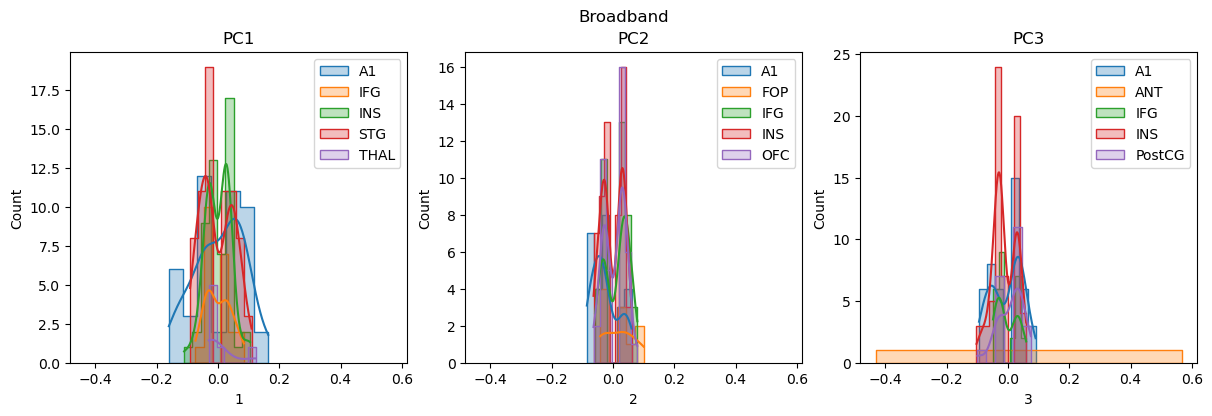

In [9]:
fig, ax = plt.subplots(1, nb_compo, figsize = (nb_compo*4, 4), sharex=True)
fig.suptitle('Broadband')
fig.tight_layout()
for i in range(nb_compo) : 
    area_list_PC = np.unique(largest_list[i].area)
    for area in area_list_PC[:5] :  
        sns.histplot(df_data.set_index('area').loc[area, i+1], stat='count', element='step', ax= ax[i], kde=True, alpha = 0.3, fill=True, label = area)
    ax[i].set_title('PC' + str(i+1))
    ax[i].legend()
plt.show()

In [10]:
for i in range(nb_compo) :
    area_to_check = np.unique(largest_list[i].area)
    fig, axs = plt.subplots(1, len(area_to_check), figsize= (len(area_to_check)*4, 5))
    fig.suptitle('PC' + str(i+1))
    for ax, area in zip(axs,area_to_check) : 
        largest = largest_list[i]
        elect_to_check = largest[largest['area'] == area].elect
        id_elect_to_check = [elect_list.index(el) for el in elect_to_check] 
        ax.plot(data_grp[1,id_elect_to_check, :].T)
        ax.set_title(area)

In [11]:
# heatmap of the channels distribution
area_to_check = np.unique(largest_list[0].area[:10])

fig, ax = plt.subplots(1, len(area_to_check), figsize = (len(area_to_check)*4, 4))
fig.tight_layout()
fig.suptitle('Broadband', y= 1.1, size=15)
vlim = 0.2

for i, area_selec in enumerate(area_to_check) :  
    df_subset = df_data[df_data['area'] == area_selec]
    sns.heatmap(df_subset.drop(columns = ['elect', 'area']), center = 0, vmax = 0.2, vmin = -0.2, cmap = 'seismic', ax= ax[i], yticklabels=False)
    ax[i].set_title(area_selec)
    ax[i].set_ylabel('Channels')
    ax[i].set_xlabel('PCs')


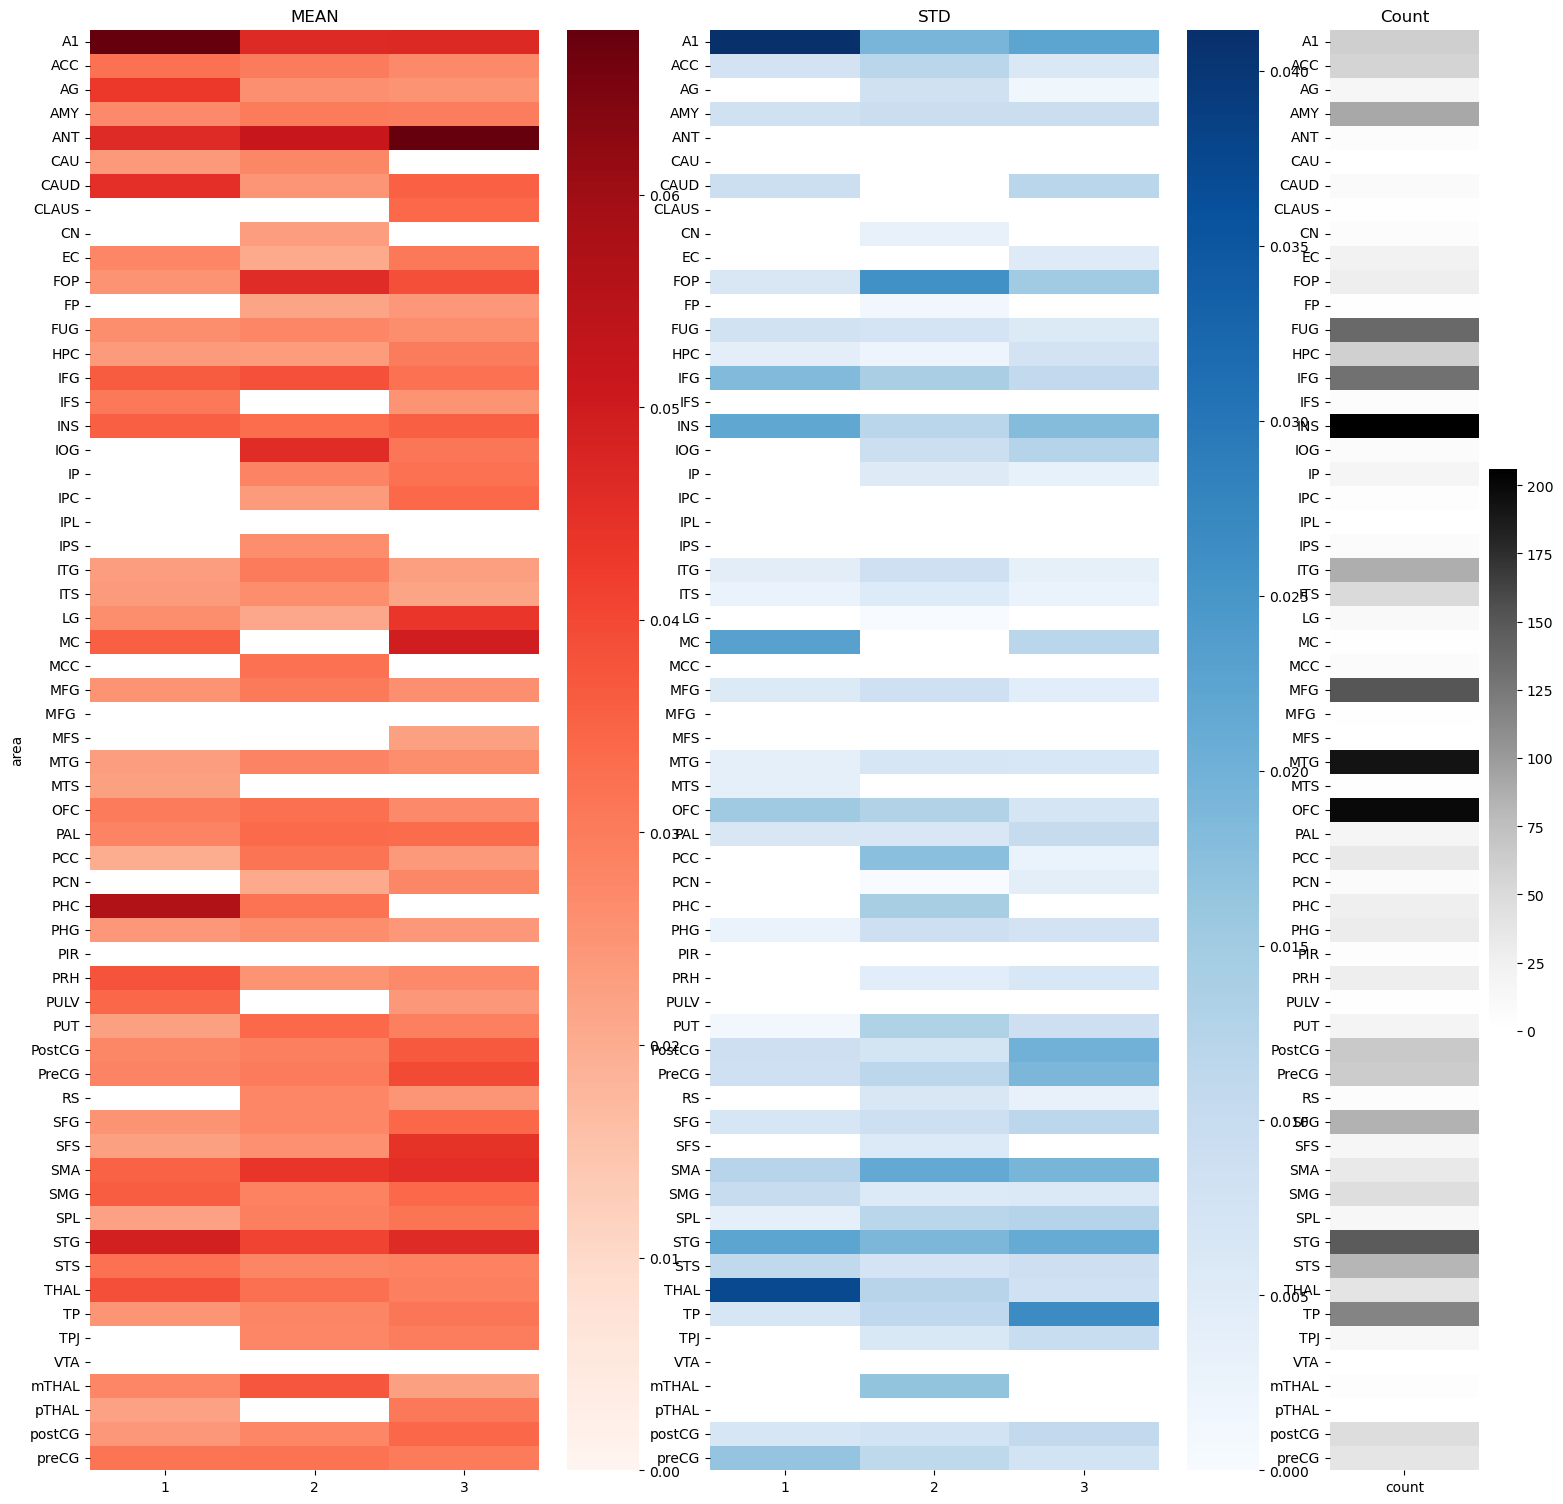

In [21]:
vlim = np.max(df_data.drop(columns ='elect').groupby('area').mean())
fig, ax = plt.subplots(1, 3, figsize = (15, 15), width_ratios=[3/7, 3/7, 1/7])
fig.tight_layout()
df_data.loc[:, [1, 2, 3]] = df_data.loc[:, [1, 2, 3]].apply(lambda x : np.abs(x))

sns.heatmap(df_data.drop(columns ='elect').groupby('area').mean(), vmin= 0, vmax = vlim, cmap = 'Reds', ax= ax[0], yticklabels=df_data.drop(columns ='elect').groupby('area').mean().index)
ax[0].set_title('MEAN')

vlim = np.max(df_data.drop(columns ='elect').groupby('area').std())
sns.heatmap(df_data.drop(columns ='elect').groupby('area').std(), vmin= 0, vmax = vlim, cmap = 'Blues', ax= ax[1], yticklabels=df_data.drop(columns ='elect').groupby('area').std().index)
ax[1].set_ylabel('')
ax[1].set_title('STD')

vlim = np.max(df_data['area'].value_counts())
count = pd.DataFrame(df_data['area'].value_counts(sort=False))
count = count.loc[df_data.drop(columns ='elect').groupby('area').std().index]

sns.heatmap(count, vmin= 0, vmax = vlim, cmap = 'Greys', ax= ax[2], yticklabels=count.index)
ax[2].set_ylabel('')
ax[2].set_title('Count')

plt.show()

#### K-mean clustering

In [13]:
# run kmean clustering on each freq bar and find the optimal numer of clusters
data = grp_compo.query("freq == 'broadband'").drop(columns = ['compo', 'freq']).values
weight_data_b = CompoThr(data, replace = 0).T

scaler = StandardScaler(with_std=False, with_mean=False)
weight_data_b = scaler.fit_transform(weight_data_b)

silhouette_avg = []
range_n_clusters = np.arange(2, 10)
for n_clusters in range_n_clusters : 
    cl = KMeans(n_clusters)
    cl.fit(weight_data_b)
    cluster_labels = cl.labels_
    silhouette_avg.append(silhouette_score(weight_data_b, cluster_labels))
ncl_best = range_n_clusters[silhouette_avg.index(max(silhouette_avg))]
sil_score = max(silhouette_avg)
kmean = KMeans(ncl_best).fit(weight_data_b)
labels = kmean.labels_.T

Text(0.5, 1.0, 'Broadband -- silhouette score : 0.68')

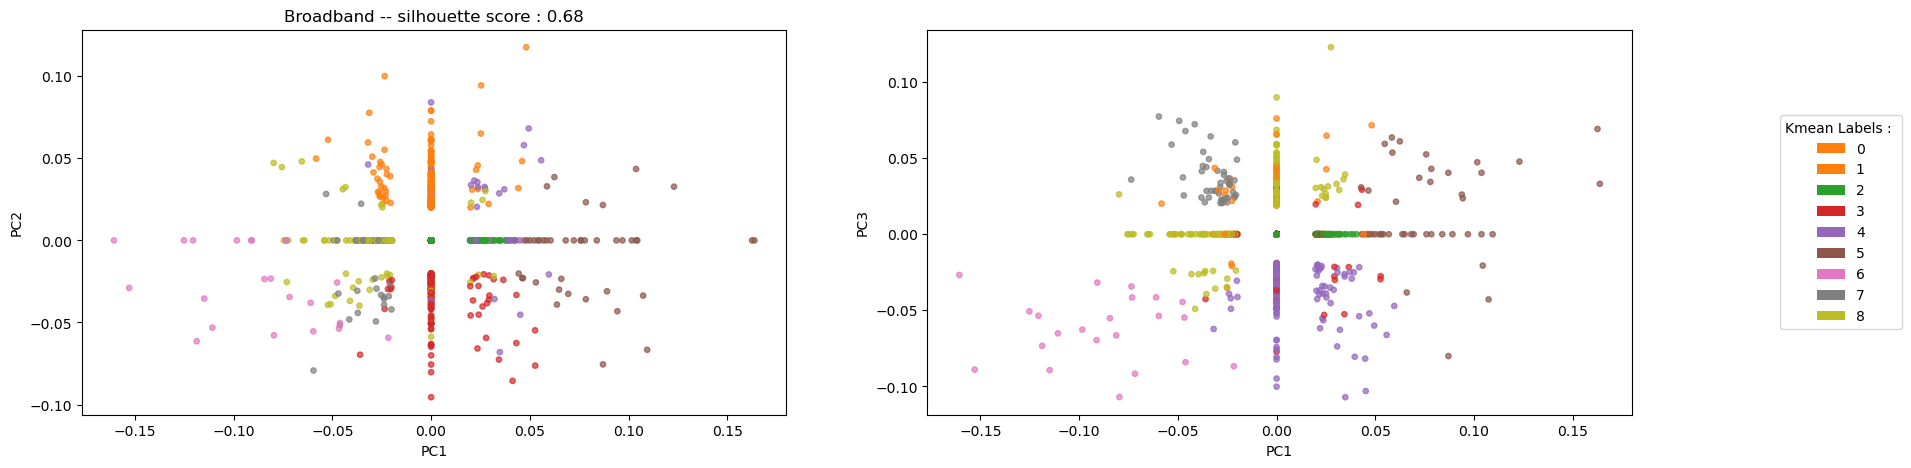

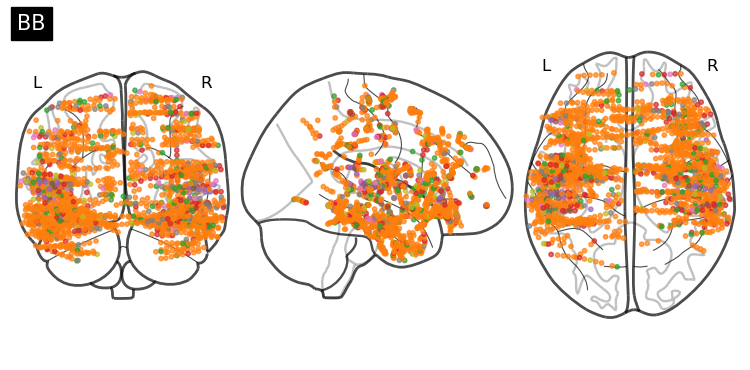

In [14]:
# plot 
base_cmap = plt.cm.tab10  
fig, ax = plt.subplots(1, nb_compo-1, figsize = (20, 5))
weight_data_b_c1 = weight_data_b[:, 0]

idx = np.where(labels >= 1)[0]
colors = [base_cmap(i) for i in np.unique(labels[idx])]
custom_cmap = ListedColormap(colors, name=f'tab20_{len(np.unique(labels[idx]))}')
legend_elements = [Patch(facecolor=custom_cmap(i / len(np.unique(labels))), label=str(lbl)) for i, lbl in enumerate(np.unique(labels))]

for sec_pc in range(nb_compo-1) : 
    weight_data_b_sec = weight_data_b[:,sec_pc +1]
    ax[sec_pc].scatter(weight_data_b_c1,weight_data_b_sec, c= labels, cmap=custom_cmap, alpha=0.7, s=15)
    ax[sec_pc].set_xlabel('PC1')
    ax[sec_pc].set_ylabel('PC' + str(sec_pc+2))

fig = plotting.plot_markers(node_coords=coord_array[idx],node_values=labels[idx],node_size=10,node_cmap=custom_cmap,title='BB',display_mode='ortho', colorbar=False)
ax[sec_pc].legend(handles=legend_elements, title="Kmean Labels : ", bbox_to_anchor=(1.2, 0.5), loc='center left')
ax[0].set_title('Broadband -- silhouette score : ' + str(np.round(sil_score, 2)))

In [15]:
cls_to_try  = np.arange(2, 10)

labels={}
data = grp_compo.query("freq == 'broadband'").drop(columns = ['compo', 'freq']).values
weight_data_b = CompoThr(data, replace = 0).T
scaler = StandardScaler(with_std=False, with_mean=False)
weight_data_b = scaler.fit_transform(weight_data_b)

Z = linkage(weight_data_b, method='ward', metric='euclidean')

# optimize number cluster 
silhouette_scores = []
for k in cls_to_try:
    l = fcluster(Z, k, criterion='maxclust')
    sil = silhouette_score(weight_data_b, l)
    silhouette_scores.append(sil)

k = cls_to_try[silhouette_scores.index(max(silhouette_scores))]
labels = fcluster(Z, k, criterion='maxclust')


In [16]:
idx = np.where(labels !=5 )[0]
colors_w0 = [base_cmap(i) for i in np.unique(labels)]
custom_cmap_w0 = ListedColormap(colors_w0, name=f'tab20_{len(np.unique(labels))}')
fig = plotting.plot_markers(node_coords=coord_array[idx],node_values=labels[idx],node_size=6,node_cmap=custom_cmap_w0,title='Broadband',display_mode='ortho', colorbar=False)


## TIME SERIE ANALYSIS

In [17]:
# Compo analysis 
nb_compo=3
grp_TS=pd.read_csv(f'{OUT_PATH}/grpPCA/supsubj_bb_mean/grp_Xtrans_PCA{nb_compo}.csv').drop(columns = 'Unnamed: 0')
subj_TS=pd.read_csv(f'{OUT_PATH}/subjPCA/Broadband/subj_Xtrans_PCA{nb_compo}.csv').drop(columns = 'Unnamed: 0')

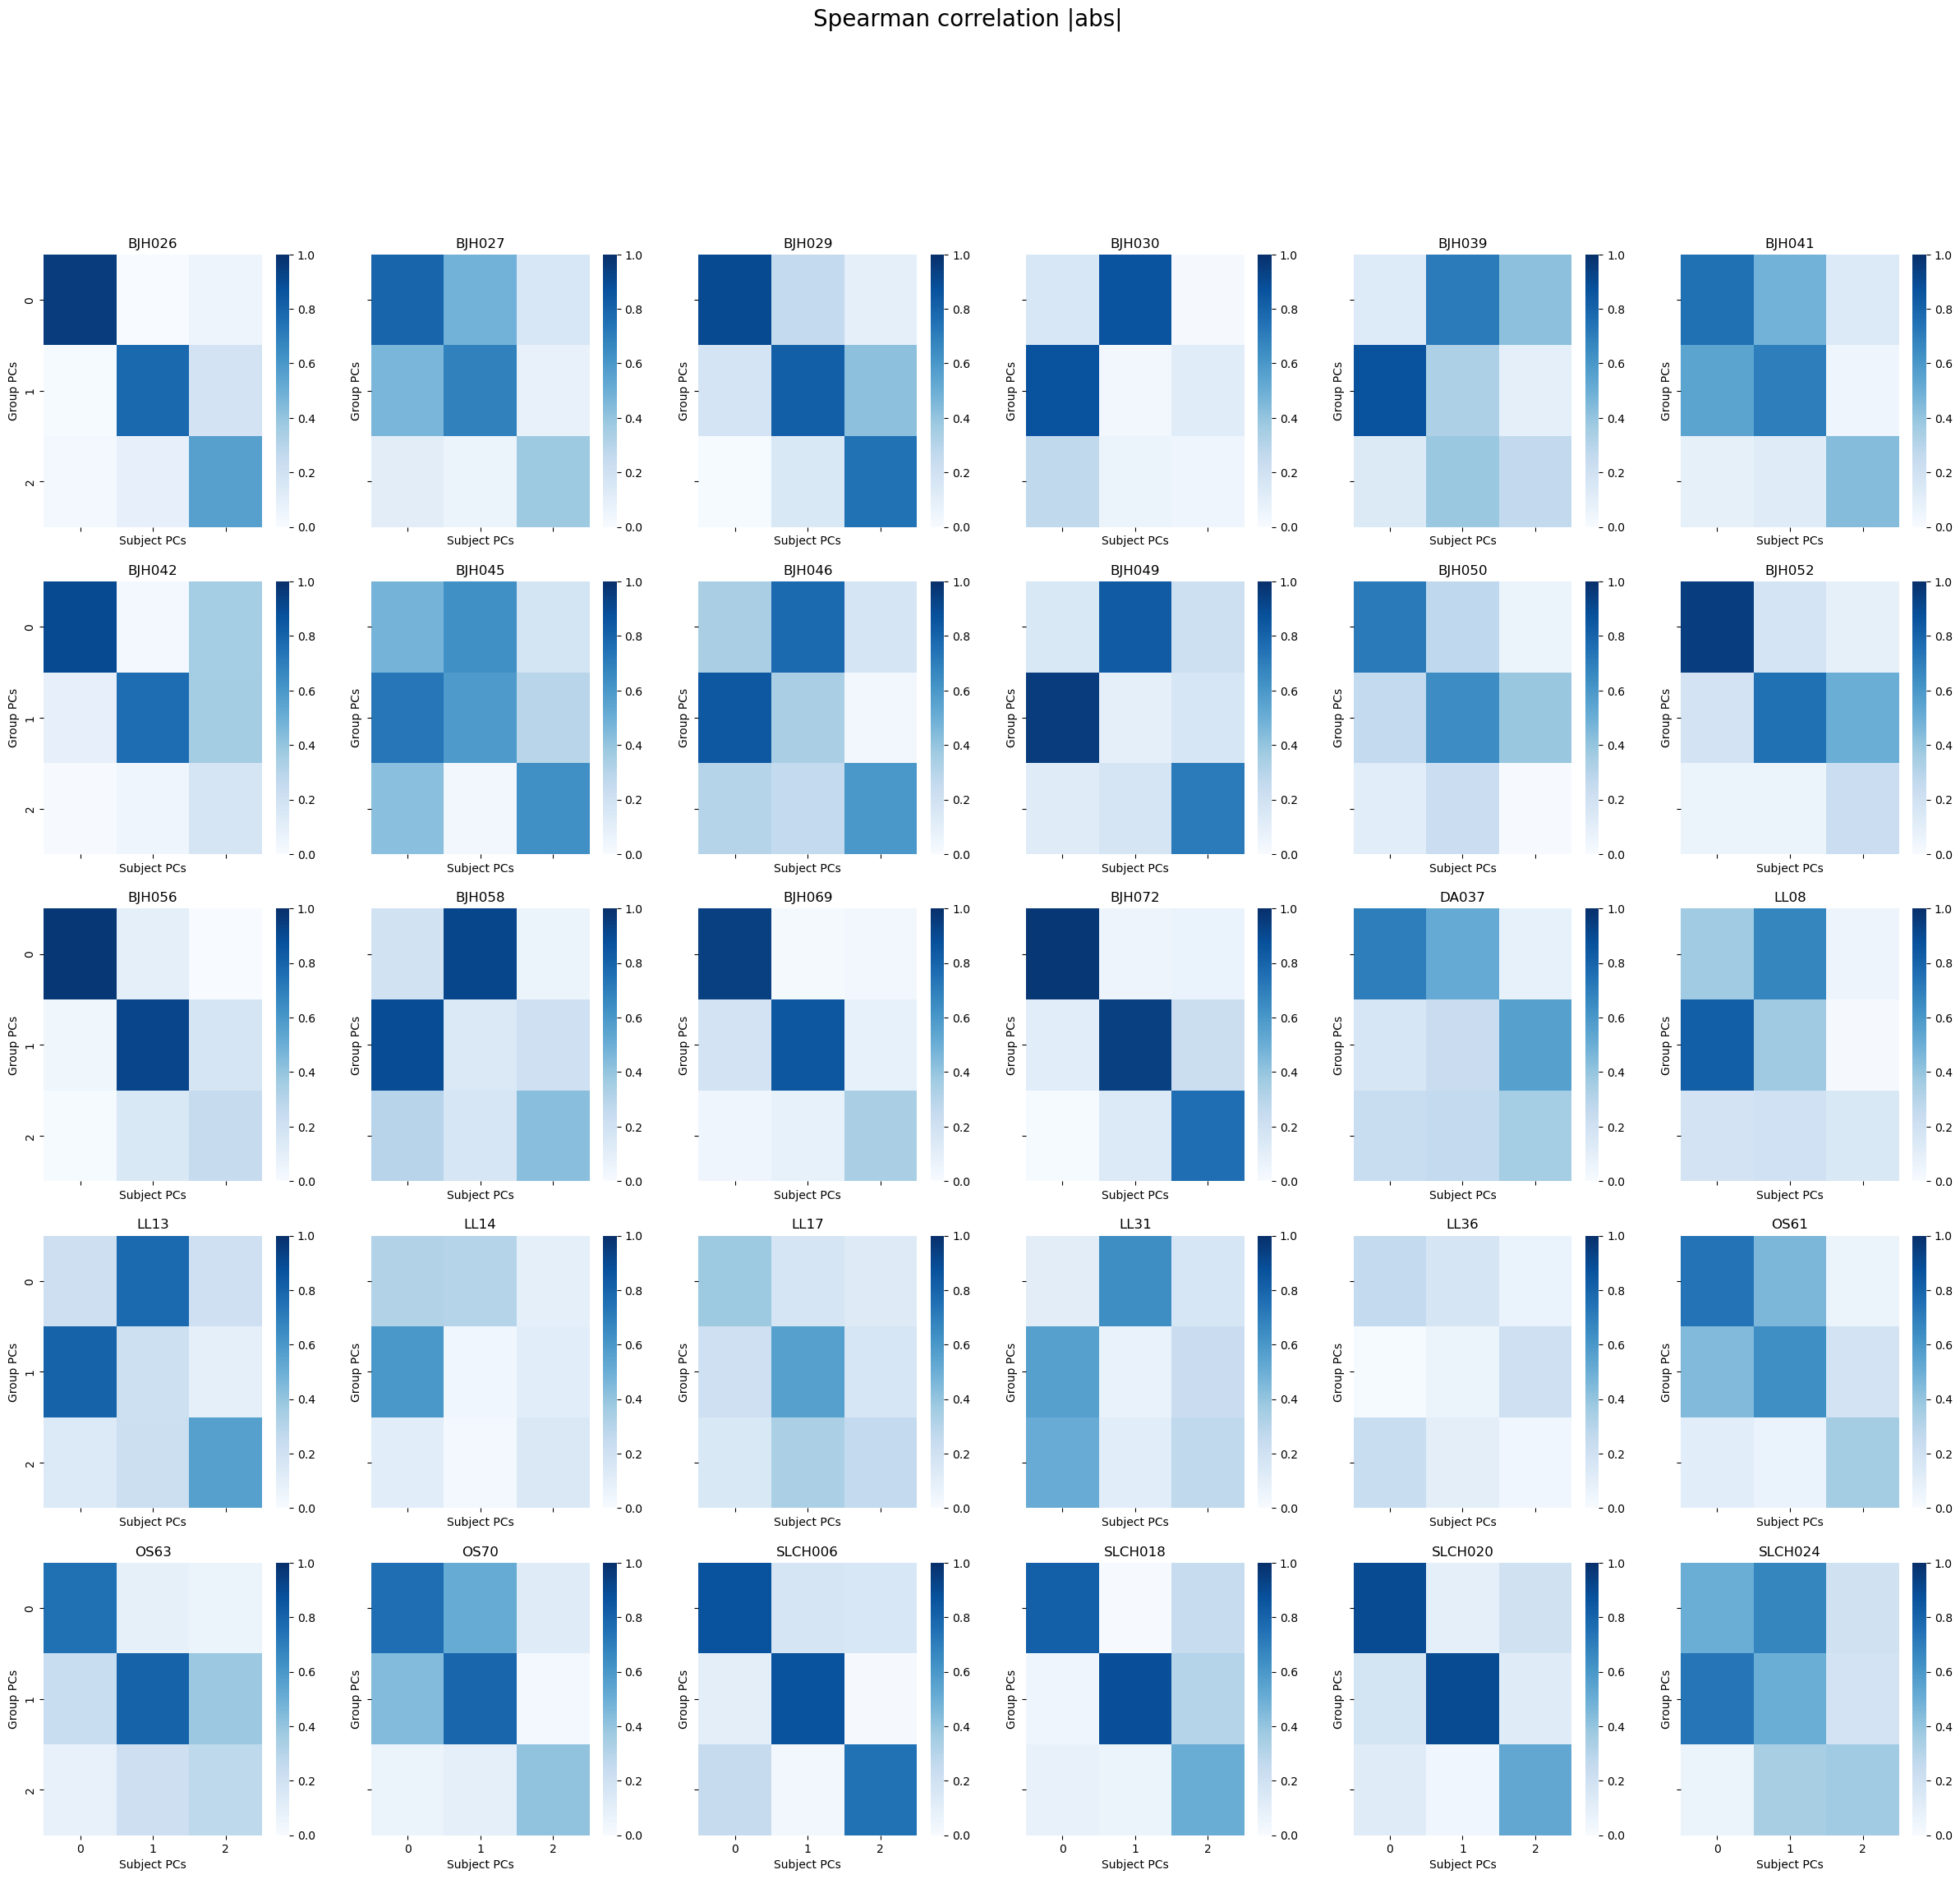

In [18]:
# Correlation table
row_nb = len(np.unique(subj_TS.subj))%5
if row_nb == 0 : row_nb = 5 
col_nb = int(len(np.unique(subj_TS.subj))/5)
if col_nb == 0 : col_nb=1

fig, ax = plt.subplots(row_nb,col_nb, sharey=True, sharex=True, figsize = (col_nb*5, row_nb*5))
fig.suptitle('Spearman correlation |abs|', y=1., size = 20)
#fig.tight_layout()
index_col = grp_TS.columns[-4]

for a, subj in zip(ax.flatten(), np.unique(subj_TS.subj)) : 
    subj_df = subj_TS.query('subj == @subj')
    corr= spearmanr(grp_TS.loc[:, :index_col].T, subj_df.loc[:, :index_col].T)[0][:nb_compo, nb_compo:nb_compo*2]
    sns.heatmap(abs(corr), ax=a, cmap='Blues', vmax = 1, vmin= 0)
    a.set_xlabel('Subject PCs')
    a.set_ylabel('Group PCs')
    a.set_title(subj)
plt.show() 

In [19]:
# built up catergories 
# make categories according to correlation
cat_1 = [] # Cat 1 -- correlation compo 0 - compo 0 
cat_2 = [] # Cat 2 -- correlation compo 1 or 2 -- Noise 
cat_3 = [] # Cat 3 -- correlation main compo latter in subjPC
cat_4 = [] # non of them 

for a, subj in zip(ax.flatten(), np.unique(subj_TS.subj)) : 
    subj_df = subj_TS.query('subj == @subj')
    corr= spearmanr(grp_TS.loc[:, :'321'].T, subj_df.loc[:, :'321'].T)[0][:nb_compo, nb_compo:nb_compo*2]

    if abs(corr[0][0]) >= 0.7 : 
        cat_1.append(subj)
        continue # if highly correlate with the 1 componant do not enter in any other condition 

    if any(abs(corr[0,:]) >= 0.6) :
        cat_3.append(subj) # if correlate with the 1 of the picks componant do not enter in any other condition 
        continue

    if any(abs(corr[1][:]) >= 0.6) or any(abs(corr[2][:]) >= 0.6) : 
        cat_2.append(subj) # correlate with noisy componant

    if subj not in cat_2 and subj not in cat_3 : 
        cat_4.append(subj) # others

In [22]:
# Get the time series with overlapping correlated grp compo
cat = cat_1
fig, ax=plt.subplots(len(cat), nb_compo, figsize = (20, 2*len(cat)))
fig.tight_layout()

for i, subj in enumerate(cat) : 
    if len(cat) == 1 : 
        the_ax = ax
    else : the_ax = ax[i]

    subj_df = subj_TS.query('subj == @subj').set_index('compo')
    
    for j in range(nb_compo) : 
        the_ax[j].plot(subj_df.loc[f'compo{j+1}', :index_col].values)
        the_ax[j].set_xticklabels([])
    the_ax[0].plot(grp_TS.set_index('compo').loc['compo1', :index_col].values, color = 'red')
    the_ax[0].set_title(subj) 